# 1. Importações de bibliotecas e carregamento de dados

In [1]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 135 kB 5.6 MB/s 
     |████████████████████████████████| 1.6 MB 44.4 MB/s 


In [2]:
# Importando bibliotecas necessárias
import json
import numpy as np
import pandas as pd
import math
import sys
import os
import seaborn as sns
import tensorflow as tf
import keras_tuner as kt
from numpy import zeros, array, asarray
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from matplotlib import pyplot
from matplotlib.pyplot import figure
from keras import metrics
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense, Dropout, Activation
from keras.layers import Flatten
from keras.layers import Embedding
from wordcloud import WordCloud

In [3]:
# Parametros modificados com frequência
debug = True
col_switch = ('summary', 'description')
xcol = col_switch[1]
translate_enabled = False
reuse_translated = True

# Esses são importantes
rstate = 7
docs_length = 'mean'
custom_doc_len = 96
z_score_threshold = 1
z_score_times = 5
embedding_size = 64
emb_model_learning_rate = 0.007
wind = 15
mcount = 5
norm_vectors = True
lstm = True
dense_layers = False
dropout = True
dropout_default_value = 0.8
opt_lr = 0.01164
ctered = True
num_epochs = 100
batch_size = 128
validation_size = 0.3

In [4]:
# Abrindo dados como ndarray
if not reuse_translated:
  data = []
  path = './drive/MyDrive/ColabNotebooks/data/'
  filelist = os.listdir(path)
  filelist.sort()
  repo_num = len(filelist)
  print("Numero de repositorios: {}".format(repo_num))
  for filename in filelist:
    with open(path + filename, 'r') as file:
      repo = json.load(file)
      data += repo
  ndata = pd.DataFrame(data).values
  pd_data = pd.DataFrame(data)
  if debug:
    print(ndata)
    print(ndata.shape)

In [5]:
# Funções auxiliares
def print_all(df):
  with pd.option_context('display.max_rows', None):
    print(df)

def my_zscore(x):
  return ((x - x.mean())/x.std())

# 2. Limpeza dos dados

In [6]:
if not reuse_translated:  
  # Removendo linhas com description null
  bool_series = pd.notnull(pd_data['description']) 
  pd_data = pd_data[bool_series]

  nan_value = float("NaN")

  pd_data.replace("", nan_value, inplace=True)
  pd_data.replace(" ", nan_value, inplace=True)
  pd_data.replace("nan", nan_value, inplace=True)

  pd_data.dropna(subset = ["description"], inplace=True)

  # Removendo linhas com summary null
  bool_series = pd.notnull(pd_data['summary']) 
  pd_data = pd_data[bool_series]

  # Removendo linhas com timespent null
  bool_series = pd.notnull(pd_data['timespent']) 
  pd_data = pd_data[bool_series]

In [7]:
# Funções para realizar limpeza nos textos
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

def id_removes(text):
  return re.sub('\[(\w|\W)*\]', '', text)

def link_removes(text):
  return re.sub('(http:|https:)\/\/(\w+|\W+\.\w+\W+(\.\w+\W+)*)(\/\w+|\W+|\w+)*', '', text)

def remove_stop_words(text):
  stop_words = set(stopwords.words('english'))
  word_tokens = word_tokenize(text)
  filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
  return ' '.join(filtered_sentence)

def stemming(text):
  ps = PorterStemmer()
  words = word_tokenize(text)
  stemmed_sentence = [ps.stem(w) for w in words]
  return ' '.join(stemmed_sentence)

def lemmatize(text):
  words = word_tokenize(text)
  le = WordNetLemmatizer()
  lemmatized_sentence = [le.lemmatize(w) for w in words]
  return ' '.join(lemmatized_sentence)

def num_remove(text):
  word_tokens = word_tokenize(text)
  non_num_seq = []
  for word in word_tokens:
    if re.match('\d+', word):
      non_num_seq.append(re.sub('\d+', '', word))
    else:
      non_num_seq.append(word)
  return ' '.join(non_num_seq)

def len_cut(text):
  word_tokens = word_tokenize(text)
  cutted = [w for w in word_tokens if not len(w) == 1]
  return ' '.join(cutted)

def list_to_str(text_list):
  sentence_agg = ''
  for item in text_list:
    sentence_agg += item
    sentence_agg += ' '
  return sentence_agg.rstrip()

def clean_str(my_str):
  clean_list = ["'", "(", ")"]
  space_list = [".", "-", "/", "#", ":", "<", ">", "_", "[", "]", "+", "{", "}", "!", "@", "$", "%", "*", "=", "…", "?", "`", ",", "\r", "\n", "\d", '"', "~", "^", "PR", "|", "&"]
  for ccrt in clean_list:
    if(ccrt in my_str):
      my_str = my_str.replace(ccrt,"")  
  for scrt in space_list:
    if(scrt in my_str):
      my_str = my_str.replace(scrt," ")
  return my_str.lower()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [8]:
if not reuse_translated:
  # Aplicando funções de limpeza textual
  resumo = pd_data['summary'].apply(list_to_str) 
  resumo = resumo.apply(id_removes)  
  resumo = resumo.apply(clean_str)
  resumo = resumo.apply(remove_stop_words)
  resumo = resumo.apply(lemmatize)
  # resumo = resumo.apply(stemming)
  resumo = resumo.apply(num_remove)
  resumo = resumo.apply(len_cut)
  resumo.replace('', np.nan, inplace=True)
  resumo.astype(str)

  tempo = pd_data['timespent']

  descricao = pd_data['description'].apply(list_to_str)  
  descricao = descricao.apply(id_removes)
  descricao = descricao.apply(link_removes)
  descricao = descricao.apply(clean_str)
  descricao = descricao.apply(remove_stop_words)
  descricao = descricao.apply(lemmatize)
  # descricao = descricao.apply(stemming)
  descricao = descricao.apply(num_remove)
  descricao = descricao.apply(len_cut)
  descricao.replace('', np.nan, inplace=True)

In [9]:
if not reuse_translated:
  # Recriando o dataset somente com as colunas necessárias
  pd_data = pd.DataFrame()
  pd_data['summary'] = resumo
  pd_data['description'] = descricao
  pd_data['timespent'] = tempo

In [10]:
if not reuse_translated:  
  # Convertendo o timespent para float
  pd_data['timespent'] = pd_data.timespent.astype(float)

  # Removendo linhas com description null
  bool_series = pd.notnull(pd_data['description']) 
  pd_data = pd_data[bool_series]

  nan_value = float("NaN")

  pd_data.replace("", nan_value, inplace=True)
  pd_data.replace(" ", nan_value, inplace=True)
  pd_data.replace("nan", nan_value, inplace=True)

  pd_data.dropna(subset = ["description"], inplace=True)

  # Removendo linhas com summary null
  bool_series = pd.notnull(pd_data['summary']) 
  pd_data = pd_data[bool_series]

  # Removendo linhas com timespent null
  bool_series = pd.notnull(pd_data['timespent']) 
  pd_data = pd_data[bool_series]
  pd_data

# 3. Remoção inicial de outliers

In [11]:
if not reuse_translated: 
  # Aplicando o zscore para remoção dos outliers
  cara =  my_zscore(pd_data['timespent'])
  df_sem_outlier_z = pd.DataFrame(
      pd_data[(abs(cara) < z_score_threshold)])

  for i in range(z_score_times):
    cara =  my_zscore(df_sem_outlier_z['timespent'])
    df_sem_outlier_z = pd.DataFrame(
        df_sem_outlier_z[(abs(cara) < z_score_threshold)])

  df_sem_outlier_z.boxplot('timespent')

In [12]:
if not reuse_translated: 
  df_sem_outlier_z.hist('timespent')

In [13]:
if not reuse_translated: 
  df_sem_outlier_z

In [14]:
if not reuse_translated: 
  data = df_sem_outlier_z

In [15]:
if not reuse_translated: 
  import os
  os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "./drive/MyDrive/ColabNotebooks/mlsdee-1584025432698-0d10d20cb49c.json"
  print(os.environ['GOOGLE_APPLICATION_CREDENTIALS'])

In [16]:
# Função para tradução
from google.cloud import translate_v3beta1 as translate

def translate_text(text="YOUR_TEXT_TO_TRANSLATE", src_lang='pt', project_id="YOUR_PROJECT_ID"):
    """Translating Text."""

    client = translate.TranslationServiceClient()

    location = "global"

    parent = f"projects/{project_id}/locations/{location}"

    response = client.translate_text(parent=parent,
            contents=[text],
            mime_type="text/plain",
            source_language_code=src_lang,
            target_language_code="en-US"
    )

    return response.translations[0].translated_text

def detect_language(text="YOUR_TEXT_TO_DETECT", project_id="YOUR_PROJECT_ID"):
    """Detecting the language of a text string."""

    client = translate.TranslationServiceClient()

    location = "global"

    parent = f"projects/{project_id}/locations/{location}"

    response = client.detect_language(
        content=text,
        parent=parent,
        mime_type="text/plain"
    )

    return response.languages[0].language_code

In [17]:
# Traduzir tudo para o inglês
translated_count = 0

def detect_and_translate(text):
  global translated_count

  detected = detect_language(text, 'mlsdee-1584025432698')

  if detected == 'en' or detected == 'en-US' or detected == 'und':
    return text

  translated_count += 1
  print(translated_count)
  print(detected)
  print(text)
  result = translate_text(text, detected, 'mlsdee-1584025432698')
  print(result)
  return result


In [18]:
if translate_enabled:
  data['summary'] = data['summary'].apply(detect_and_translate)
  data['description'] = data['description'].apply(detect_and_translate)
  data.to_csv('data.csv', index=False)

In [19]:
# Garantir que obtem os dados traduzidos
if reuse_translated: 
  data = pd.read_csv('./drive/MyDrive/ColabNotebooks/data.csv')

# 4. Análise exploratória dos dados

In [20]:
data

,summary,description,timespent
0,contrib graphic remove body attribute example ...,know core model attribute actually used compon...,1800.0
1,unused color variable,remove color le file use theme,1800.0
2,grunt task runner dev task copy json change build,watch task run grunt dev watch change config j...,1800.0
3,narrative component,heading component item stacked top see button ...,1800.0
4,play ended completion event dont work source v...,look like mediaelement doesnt broadcast event ...,1800.0
...,...,...,...
12036,log time previous work,import working hour per year per user andi uli...,2400.0
12037,build server continuous integration based bamboo,setup bamboo server xenoage utils create job b...,1800.0
12038,source code management based github,install stash move zong xenoage utils reposito...,1800.0
12039,javafx utils new project,move generally useful javafx utils new project...,2700.0


[1320. 1380. 1440. 1488. 1500. 1560. 1620. 1680. 1692. 1740. 1800. 1815.
 1830. 1860. 1890. 1920. 1980. 2040. 2052. 2088. 2100. 2160. 2220. 2268.
 2280. 2340. 2400. 2412. 2448. 2460. 2520. 2580. 2628. 2640. 2700. 2715.
 2760. 2820. 2880. 2940. 3000. 3012. 3048. 3060. 3120. 3168. 3180. 3240.
 3276. 3300. 3312. 3360. 3420. 3480.]
54


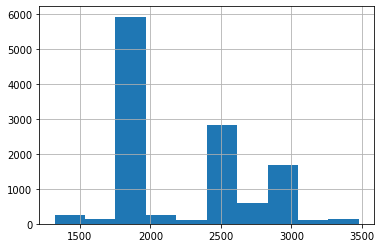

In [21]:
# Verificando quais os tempos estimados existentes e observando algumas estatísticas
uniq = data['timespent'].unique()
uniq.sort(axis=0)
print(uniq)
print(len(uniq))

mode = data['timespent'].mode()[0]
median = data['timespent'].median()
mean = data['timespent'].describe()['mean']
std = data['timespent'].describe()['std']

data['timespent'].hist()
# Boxplot ou diagrama de distribuiçao

In [22]:
data['timespent'].describe()

count    12041.000000
mean      2186.462835
std        480.078739
min       1320.000000
25%       1800.000000
50%       1800.000000
75%       2400.000000
max       3480.000000
Name: timespent, dtype: float64

# Criação do modelo

In [23]:
# Obtendo todos os docs das description e summary para serem treinadas
all_text = []
for des_str in data['description'].values:
  des_str = clean_str(des_str)
  all_text.append(des_str.split())

for sum_str in data['summary'].values:
  sum_str = clean_str(sum_str)
  all_text.append(sum_str.split())

if debug:
  print(len(all_text))

24082


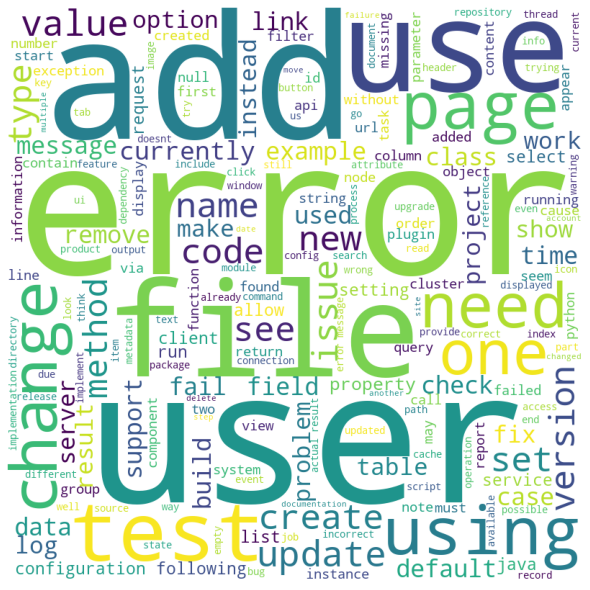

In [24]:
# Criando a nuvem de palavras do texto antes de treinar o modelo
def plot_word_cloud(words):
  text_joined = ' '.join(words)
  wordcloud = WordCloud(width = 800, height = 800,
                  background_color ='white',
                  min_font_size = 10).generate(text_joined)

  pyplot.figure(figsize = (8, 8), facecolor = None)
  pyplot.imshow(wordcloud)
  pyplot.axis("off")
  pyplot.tight_layout(pad = 0)
  
  pyplot.show()

all_words = []
for doc in all_text:
  for word in doc:
    all_words.append(word)
    
plot_word_cloud(all_words)

In [25]:
# Definindo o modelo de word embeddings
emb_model = Word2Vec(all_text,
                     seed=rstate, 
                     sg=1,
                     hs=0, 
                     iter=num_epochs, 
                     window=wind, 
                     min_count=mcount, 
                     size=embedding_size, 
                     alpha=emb_model_learning_rate)
if norm_vectors:
  emb_model.init_sims(replace=True)
# Resumo do modelo
if debug:
  print(emb_model)
words = list(emb_model.wv.vocab)
if debug:
  print(words)

vocab_size = len(words) + 1
if debug:
  print(vocab_size)

Word2Vec(vocab=6014, size=64, alpha=0.007)
['know', 'core', 'model', 'attribute', 'actually', 'used', 'component', 'little', 'misleading', 'list', 'example', 'json', 'remove', 'color', 'le', 'file', 'use', 'theme', 'watch', 'task', 'run', 'grunt', 'dev', 'change', 'config', 'copy', 'build', 'changed', 'saved', 'replicate', 'make', 'save', 'observe', 'command', 'line', 'say', 'src', 'course', 'go', 'updated', 'heading', 'item', 'top', 'see', 'button', 'work', 'doesnt', 'also', 'occurs', 'behaviour', 'nexus', 'android', 'look', 'like', 'broadcast', 'event', 'source', 'vimeo', 'might', 'well', 'need', 'testing', 'assume', 'could', 'probably', 'hack', 'way', 'around', 'play', 'firing', 'user', 'click', 'video', 'completion', 'unlikely', 'easy', 'though', 'support', 'drop', 'shadow', 'slider', 'icon', 'effectively', 'invisible', 'attached', 'requires', 'choose', 'image', 'option', 'description', 'alt', 'text', 'question', 'visually', 'end', 'link', 'every', 'drawer', 'tabbing', 'select', 'w

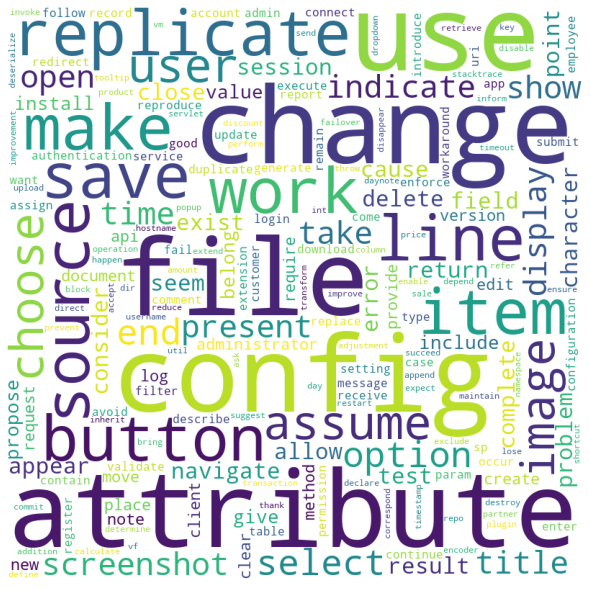

In [26]:
# Criando a nuvem de palavras do texto depois de treinar o modelo
plot_word_cloud(words)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


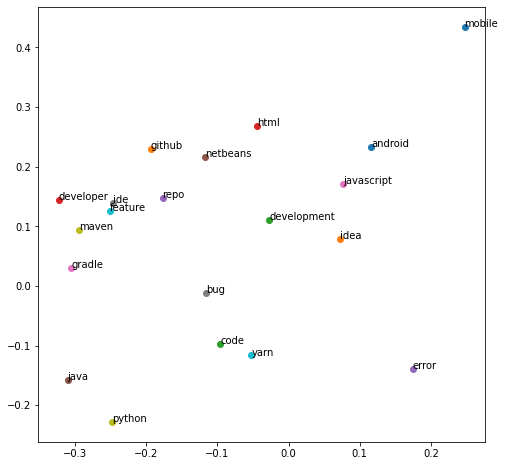

In [27]:
# Mostrando os vertores das palavras reduzidos para 2D
X = emb_model[emb_model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
pyplot.figure(figsize=(8,8))
# pyplot.scatter(result[:, 0], result[:, 1])
word_list = ['python', 
             'java', 
             'code',
             'error', 
             'bug', 
             'ide', 
             'netbeans',
             'feature', 
             'idea', 
             'developer', 
             'development', 
             'maven', 
             'gradle', 
             'android', 
             'mobile', 
             'html', 
             'yarn', 
             'repo', 
             'github', 
             'javascript']
for i, word in enumerate(words):
  if word in word_list:
    pyplot.scatter(result[i, 0], result[i, 1])
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

In [28]:
# Brincando com o modelo py
print(emb_model.wv.similarity('python', 'py'))
emb_model.wv.most_similar(positive=['graph'], topn=10)

0.64305305


[('grow', 0.6352847814559937),
 ('grows', 0.6255636215209961),
 ('oltp', 0.6237931251525879),
 ('ro', 0.5997181534767151),
 ('bolt', 0.5802050828933716),
 ('smooth', 0.5675228834152222),
 ('estimate', 0.5651787519454956),
 ('commit', 0.5639768838882446),
 ('gettime', 0.5537706613540649),
 ('comparator', 0.551445722579956)]

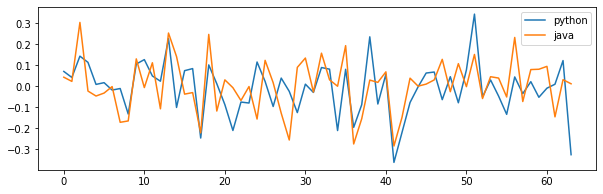

In [29]:
# Comparando vetores de palavras
pyplot.figure(figsize=(10,3))
w1 = 'python'
w2 = 'java'
w1v = emb_model.wv.get_vector(w1)
w2v = emb_model.wv.get_vector(w2)
pyplot.plot(w1v, label=w1)
pyplot.plot(w2v, label=w2)
pyplot.legend()
pyplot.show()

In [30]:
# Obtendo a lista de docs concatenando summary + description
docs = []
for i in range(len(data)):
  summ = data['summary'].values[i]
  desc = data['description'].values[i]
  docs.append(summ + " " + desc)
for i in range(10):
  print(docs[i])
print(len(docs))

contrib graphic remove body attribute example json know core model attribute actually used component little misleading list example json
unused color variable remove color le file use theme
grunt task runner dev task copy json change build watch task run grunt dev watch change config json copy config json build file changed saved replicate run grunt dev make change save file observe command line say file src course config json changed copy coursejson task run go observe config json updated
narrative component heading component item stacked top see button work button doesnt also occurs behaviour nexus android
play ended completion event dont work source vimeo look like mediaelement doesnt broadcast event source vimeo might well youtube need testing assume could probably hack way around play event firing user click video completion event unlikely easy though
slider doesnt support drop shadow slider icon effectively invisible see attached
question accessible mcq requires user choose image

In [31]:
# Criando coluna com o tamanho dos docs
docs_len = []
for doc in docs:
  docs_len.append(len(doc.split()))
print(docs_len[0:10])

[19, 9, 52, 17, 38, 11, 19, 26, 15, 17]


In [32]:
df_sem_outlier_z = data

In [33]:
df_sem_outlier_z['docs_lens'] = docs_len

In [34]:
df_sem_outlier_z

,summary,description,timespent,docs_lens
0,contrib graphic remove body attribute example ...,know core model attribute actually used compon...,1800.0,19
1,unused color variable,remove color le file use theme,1800.0,9
2,grunt task runner dev task copy json change build,watch task run grunt dev watch change config j...,1800.0,52
3,narrative component,heading component item stacked top see button ...,1800.0,17
4,play ended completion event dont work source v...,look like mediaelement doesnt broadcast event ...,1800.0,38
...,...,...,...,...
12036,log time previous work,import working hour per year per user andi uli...,2400.0,18
12037,build server continuous integration based bamboo,setup bamboo server xenoage utils create job b...,1800.0,34
12038,source code management based github,install stash move zong xenoage utils reposito...,1800.0,30
12039,javafx utils new project,move generally useful javafx utils new project...,2700.0,21


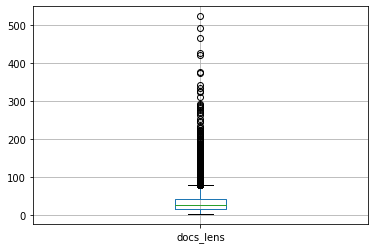

In [35]:
df_sem_outlier_z.boxplot('docs_lens')

In [36]:
# Definindo o tamanho máximo dos docs
max_length_des = 0
if docs_length == 'mean':
  max_length_des = int(df_sem_outlier_z['docs_lens'].mean())
  if debug:
    print(max_length_des)
elif docs_length == 'min':
  max_length_des = int(df_sem_outlier_z['docs_lens'].min())
  if debug:
    print(max_length_des)
else:
  max_length_des = custom_doc_len
  if debug:
    print(max_length_des)

33


In [37]:
# Teste de sanitização para verificar quantas palavras não estão nas embeddings
count = 0
for word in words:
  w_vec = emb_model.wv.get_vector(word)
  if w_vec is None:
    count += 1
print(count)

0


In [38]:
# Criando a matriz de embeddings
words_index = dict()
embedding_matrix = zeros((vocab_size, embedding_size))
for i, word in enumerate(words, start=1):
	embedding_vector = emb_model.wv.get_vector(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector
		words_index[word] = i

In [39]:
# Criando array para receber os docs codificados
doc_encoded = zeros((max_length_des))
print(doc_encoded.shape)

(33,)


In [40]:
# Codificando os documentos
padded_docs = zeros((len(docs), max_length_des))
for i, doc in enumerate(docs):
  doc_word_list = doc.split()
  doc_encoded = zeros((max_length_des))
  for j, word in enumerate(doc_word_list):
    if j < max_length_des:
      w_index = words_index.get(word)
      if w_index is not None:
        doc_encoded[j] = w_index
  padded_docs[i] = doc_encoded
padded_docs     

array([[4035., 4391.,   13., ...,    0.,    0.,    0.],
       [2252.,   14.,  142., ...,    0.,    0.,    0.],
       [  22.,   20., 3426., ...,   24.,   32.,   16.],
       ...,
       [  57.,  251., 1162., ...,    0.,    0.,    0.],
       [   0., 3538.,  573., ...,    0.,    0.,    0.],
       [  27.,  426.,  186., ...,    0.,    0.,    0.]])

In [41]:
print(padded_docs.shape)

(12041, 33)


In [42]:
# Particionando conjunto usado no hipertunning e o que sera usado para treino e teste
# [TODO] Usar um cid no hipertunning
from sklearn.model_selection import train_test_split

x_search, x_val, y_search, y_val = train_test_split(padded_docs, data['timespent'].values, test_size=validation_size, random_state=rstate)
print(x_search.shape)
print(x_val.shape)
print(y_search.shape)
print(y_val.shape)

(8428, 33)
(3613, 33)
(8428,)
(3613,)


8428

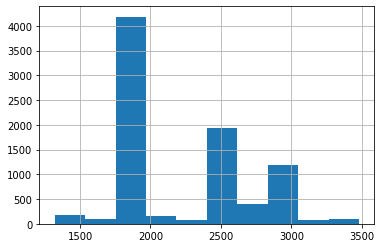

In [43]:
# Verificando o y do conjunto de treino 
ytp = pd.Series(y_search)
ytp.hist()
len(y_search)

3613

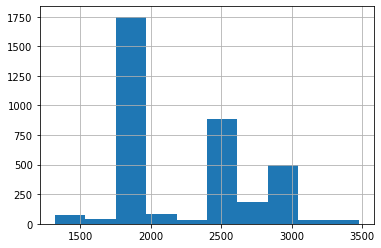

In [44]:
# Verificando o y do conjunto de teste
ytt = pd.Series(y_val)
ytt.hist()
len(y_val)

In [45]:
# Definindo o modelo
from tensorflow import keras

def compile_model(hp):
  model = Sequential()
  e = Embedding(vocab_size, embedding_size, weights=[embedding_matrix], input_length=max_length_des, trainable=False)
  hp_l1 = hp.Choice('layer_1', [16, 32, 64])
  hp_l2 = hp.Choice('layer_2', [32, 64, 128])
  model.add(e)
  model.add(Bidirectional(LSTM(hp_l1)))
  model.add(Dropout(dropout_default_value))
  model.add(Dense(hp_l2, activation='relu'))
  model.add(Dropout(dropout_default_value))
  # model.add(Dense(hp_l2, activation='relu'))
  # model.add(Dropout(dropout_default_value))
  model.add(Dense(1))
  opt = keras.optimizers.RMSprop(learning_rate=opt_lr, 
                                 centered=ctered)
  model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae', 'mean_squared_error'])
  # Resumo do modelo
  print(model.input_shape)
  print(model.summary())
  return model

In [46]:
# Definindo o tuner
tuner = kt.RandomSearch(compile_model,
                     objective='val_mae',
                     max_trials=5,
                     seed=rstate,
                     overwrite=True)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=50)

tuner.search(x_search, y_search, epochs=num_epochs, batch_size=batch_size, validation_split=validation_size, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=5)[0]

Trial 5 Complete [00h 09m 27s]
val_mae: 401.9609069824219

Best val_mae So Far: 394.31671142578125
Total elapsed time: 00h 26m 08s


In [47]:
best_hps.values

{'layer_1': 16, 'layer_2': 64}

# Treinando e avaliando o modelo

In [48]:
# Separando o conjunto de validação em treino e teste
x_train, x_test, y_train, y_test = train_test_split(x_val, y_val, test_size=validation_size, random_state=rstate)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(2529, 33)
(1084, 33)
(2529,)
(1084,)


(None, 33)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 33, 64)            384960    
                                                                 
 bidirectional (Bidirectiona  (None, 32)               10368     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                             

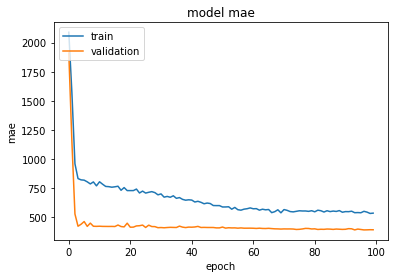

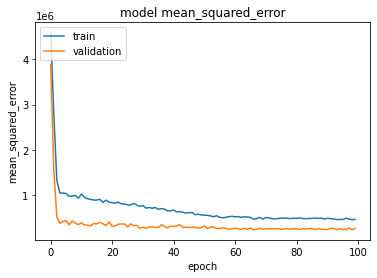

In [49]:
# Treinando com todos os datasets
from keras.backend import clear_session
clear_session()

model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=validation_size, verbose=1)

pyplot.plot(history.history['mae'])
pyplot.plot(history.history['val_mae'])
pyplot.title('model mae')
pyplot.ylabel('mae')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper left')
pyplot.show()

pyplot.plot(history.history['mean_squared_error'])
pyplot.plot(history.history['val_mean_squared_error'])
pyplot.title('model mean_squared_error')
pyplot.ylabel('mean_squared_error')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper left')
pyplot.show()

In [50]:
# Fazendo e avaliando previsões com o melhor modelo no conjunto de teste
predictions = model.predict(x_test)
print(predictions[0:10])

34/34 [==============================] - 1s 7ms/step
[[2070.846 ]
 [1988.2175]
 [2454.0813]
 [2332.115 ]
 [2180.738 ]
 [2131.1008]
 [2163.4749]
 [2188.4382]
 [2314.43  ]
 [2065.1519]]


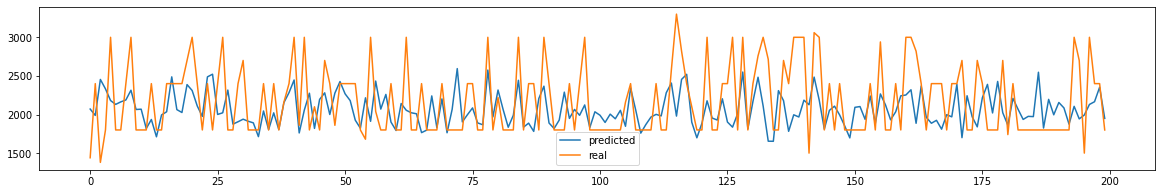

In [51]:
psize = 200
pyplot.figure(figsize=(20,3))
pyplot.plot(predictions[0:psize], label='predicted')
pyplot.plot(y_test[0:psize], label='real')
pyplot.legend()
pyplot.show()

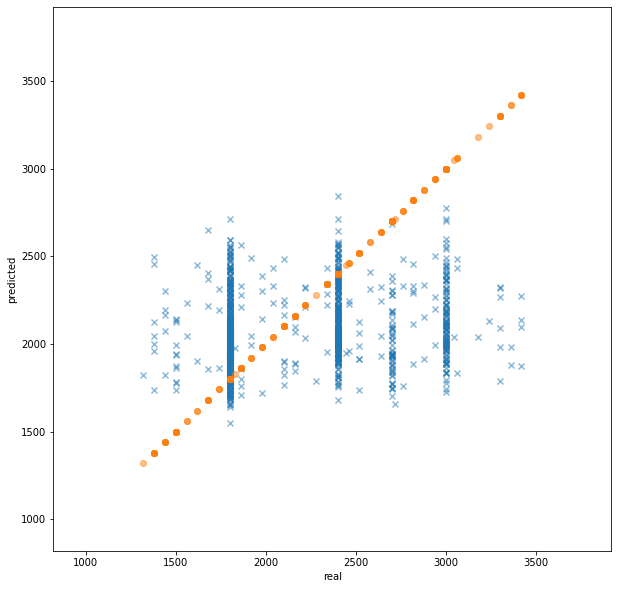

In [52]:
def plot_results(y_test, predictions):
  x_lim = max(y_test.max(), predictions.max()) + 500
  y_lim = min(y_test.min(), predictions.min()) - 500
  pyplot.figure(figsize=(10,10))
  pyplot.scatter(y_test, predictions, marker='x', alpha=0.5)
  pyplot.scatter(y_test, y_test, marker='o', alpha=0.5)
  pyplot.xlim(y_lim, x_lim)
  pyplot.ylim(y_lim, x_lim)
  pyplot.xlabel("real")
  pyplot.ylabel("predicted")
  pyplot.show()
plot_results(y_test, predictions)

In [53]:
y_test.max()

3420.0

In [54]:
predictions.max()

2840.9219

In [55]:
y_test.min()

1320.0

In [56]:
predictions.min()

1546.3179

In [57]:
# Calculando mmre and mae para validação
from sklearn.metrics import mean_absolute_error

def mre(actual, pred):
  actual += 1
  pred += 1
  mre = (abs(actual - pred)) / actual
  return mre

def mmre(y, pred):
  sum = 0.0
  for i, actual in enumerate(y):
    sum += mre(actual, pred[i])
  mmre = (sum / (len(y))) 
  return mmre

print("PARÂMETROS")
print("--------------------------------------------------------")
print("number of docs: {}".format(len(docs)))
print("vocab size: {}".format(vocab_size))
print("docs_length = {}".format(docs_length))
print("embedding_size = {}".format(embedding_size))
print("z_score_threshold = {}".format(z_score_threshold))
print("z_score_times = {}".format(z_score_times))
print("lstm = {}".format(lstm))
print("dense_layers = {}".format(dense_layers))
print("dropout  = {}".format(dropout ))
print("dropout_default_value = {}".format(dropout_default_value))
print("emb_model_learning_rate = {}".format(emb_model_learning_rate))
print("num_epochs = {}".format(num_epochs))
print("batch_size = {}".format(batch_size))
print(" ")
print("RESULTADO")
print("--------------------------------------------------------")
print("MMRE: {}".format(mmre(y_test, predictions)))
print("MAE: {}".format(mean_absolute_error(y_test, predictions)))
print("MSE: {}".format(mean_squared_error(y_test, predictions)))

PARÂMETROS
--------------------------------------------------------
number of docs: 12041
vocab size: 6015
docs_length = mean
embedding_size = 64
z_score_threshold = 1
z_score_times = 5
lstm = True
dense_layers = False
dropout  = True
dropout_default_value = 0.8
emb_model_learning_rate = 0.007
num_epochs = 100
batch_size = 128
 
RESULTADO
--------------------------------------------------------
MMRE: [0.16775051]
MAE: 381.3393190954004
MSE: 235767.6670320552


In [96]:
mean = np.full(y_train.size, np.mean(y_train))
median = np.full(y_train.size, np.median(y_train))

In [97]:
mean_mae = mean_absolute_error(y_test, mean[0:y_test.size])
median_mae = mean_absolute_error(y_test, median[0:y_test.size])
model_mae = mean_absolute_error(y_test, predictions)

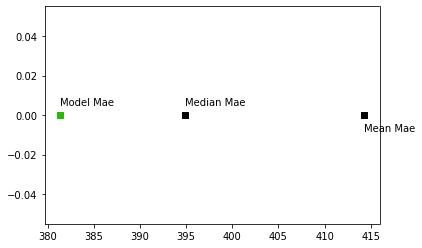

In [98]:
by = 0
ly = by + 0.005
pyplot.scatter(mean_mae, by, marker='s', c='#000000')
pyplot.annotate("Mean Mae", (mean_mae, ly - 0.013))
pyplot.scatter(median_mae, by, marker='s', c='#000000')
pyplot.annotate("Median Mae", (median_mae, ly))
if model_mae < mean_mae and model_mae < median_mae:
  mpcolor = '#27ba02'
elif model_mae <= mean_mae and model_mae >= median_mae:
  mpcolor = '#e7eb00'
elif model_mae > mean_mae and model_mae > median_mae:
  mpcolor = '#eb1000'
pyplot.scatter(model_mae, by, marker='s', c=mpcolor)
pyplot.annotate("Model Mae", (model_mae, ly))
pyplot.show()
# [DONE] Fazer o do quadrático
# [DONE] Adicionar a nuvem de palavras

In [101]:
mean_mse = mean_squared_error(y_test, mean[0:y_test.size])
median_mse = mean_squared_error(y_test, median[0:y_test.size])
model_mse = mean_squared_error(y_test, predictions)

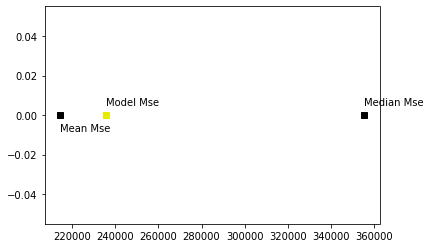

In [102]:
by = 0
ly = by + 0.005
pyplot.scatter(mean_mse, by, marker='s', c='#000000')
pyplot.annotate("Mean Mse", (mean_mse, ly - 0.013))
pyplot.scatter(median_mse, by, marker='s', c='#000000')
pyplot.annotate("Median Mse", (median_mse, ly))
if model_mse < median_mse and model_mse < mean_mse:
  mpcolor = '#27ba02'
elif model_mse <= median_mse and model_mse >= mean_mse:
  mpcolor = '#e7eb00'
elif model_mse > median_mse and model_mse > mean_mse:
  mpcolor = '#eb1000'
pyplot.scatter(model_mse, by, marker='s', c=mpcolor)
pyplot.annotate("Model Mse", (model_mse, ly))
pyplot.show()
# TODO Retirar a raíz do MSE para poder validar com MAE
# TODO Distribuição das palavras (frequencia das palavras)
# TODO Validar o m_count
# TODO Avaliar com o grid search variando os units do LSTM (tamanho da saída de cada unidade)

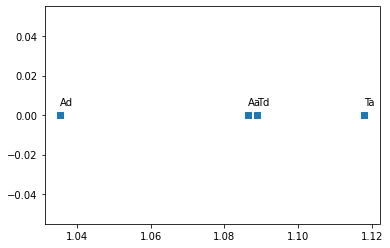

In [103]:
ta = 1.118
td = 1.089
base_y = 0
leg_y = base_y + 0.005
fa = mean_mae/model_mae
fd = median_mae/model_mae
pyplot.scatter([fa, fd, ta, td], np.full(4, base_y), marker='s')
pyplot.annotate("Aa", (fa, leg_y))
pyplot.annotate("Ad", (fd, leg_y))
pyplot.annotate("Ta", (ta, leg_y))
pyplot.annotate("Td", (td, leg_y))
pyplot.show()

In [ ]:
model_mse

# Células que ainda podem ser úteis

In [ ]:
# from datetime import datetime
# def time_calc(date1, date2):
#   pattern = "%Y-%m-%d %I:%M %p"
#   d1 = datetime.strptime(date1, pattern)
#   d2 = datetime.strptime(date2, pattern)

#   delta = d2 - d1
#   return delta.total_seconds() / 60

In [ ]:
# if not tubelis:  
#   path = './drive/MyDrive/ColabNotebooks/tasks/'
#   filelist = os.listdir(path)

#   pd_data = pd.read_csv(path + filelist[0])
#   for i in range(1, len(filelist)):
#     pd_data2 = pd.read_csv(path + filelist[i])
#     pd_data = pd.concat([pd_data, pd_data2], ignore_index=True)

#   # Removendo linhas com Resolvido null
#   bool_series = pd.notnull(pd_data['Resolvido']) 
#   pd_data = pd_data[bool_series]

#   # Removendo linhas com Criado null
#   bool_series = pd.notnull(pd_data['Criado']) 
#   pd_data = pd_data[bool_series]


In [ ]:
# Abrindo dados como ndarray
# data = []
# path = './drive/MyDrive/ColabNotebooks/data/'
# filelist = os.listdir(path)
# filelist.sort()
# # filelist = ['EVL_lab_clean.json']
# repo_num = len(filelist)
# print("Numero de repositorios: {}".format(repo_num))
# for filename in filelist:
#   with open(path + filename, 'r') as file:
#     repo = json.load(file)
#     data += repo
# ndata = pd.DataFrame(data).values
# pd_data = pd.DataFrame(data)
# if debug:
#   print(ndata)
#   print(ndata.shape)

In [ ]:
# dvc = data['timespent'].value_counts()
# dvcs = dvc.sort_index()
# dvcs.index.to_numpy().astype(str)

# pyplot.figure(figsize=(10,10))
# pyplot.bar(dvcs.index.to_numpy().astype(str), dvcs.values)
# pyplot.show()

In [ ]:
# uniq = data['timespent'].unique()
# uniq.sort(axis=0)
# print(uniq)
# print(len(uniq))

# mode = data['timespent'].mode()[0]
# median = data['timespent'].median()
# mean = data['timespent'].describe()['mean']
# std = data['timespent'].describe()['std']

# pyplot.figure(figsize=(10,5))
# pyplot.plot(uniq, label="timespent values")
# pyplot.axhline(y=mode, label="mode", color="#e6440e", linestyle="dashed", linewidth=1.2)
# pyplot.axhline(y=median, label="median", color="#7ae60e", linestyle="dashed", linewidth=1.2)
# pyplot.axhline(y=mean, label="mean", color="#e6960e", linestyle="dashed", linewidth=1.2)
# pyplot.axhline(y=std, label="std", color="#5d0ee6", linestyle="dashed", linewidth=1.2)
# pyplot.legend()
# pyplot.show()

In [ ]:
# Arquivos das embeddings pré-treinadas
# emb_file = dict()
# emb_file[50] = './drive/MyDrive/ColabNotebooks/glove.6B.50d.txt'
# emb_file[100] = './drive/MyDrive/ColabNotebooks/glove.6B.100d.txt'
# emb_file[200] = './drive/MyDrive/ColabNotebooks/glove.6B.200d.txt'
# emb_file[300] = './drive/MyDrive/ColabNotebooks/glove.6B.300d.txt'

In [ ]:
# Carregando as embeddings pré-treinadas
# embeddings_index = dict()
# f = open(emb_file.get(embedding_size))
# for line in f:
# 	values = line.split()
# 	word = values[0]
# 	coefs = asarray(values[1:], dtype='float32')
# 	embeddings_index[word] = coefs
# f.close()
# print('Loaded %s word vectors.' % len(embeddings_index))

# Quantas palavras não estão na embeddings pré treinadas
# count = 0
# for word in words:
#   if word not in embeddings_index:
#     count += 1
#     #print(word)
# print(count)

In [ ]:
# Criando a matriz de embeddings [pré-treinadas]
# words_index = dict()
# embedding_matrix = zeros((vocab_size, embedding_size))
# for i, word in enumerate(words, start=1):
# 	embedding_vector = embeddings_index.get(word)
# 	if embedding_vector is not None:
# 		embedding_matrix[i] = embedding_vector
# 		words_index[word] = i

In [ ]:
# bool_series = dvc[data["timespent"]] >= minimum_number_of_records
# data = data[bool_series.values]

In [ ]:
# # Treinando com kfolds
# from keras.backend import clear_session
# clear_session()

# from sklearn.model_selection import KFold

# kf = KFold(n_splits=3)
# foldn = 1
# acc_hist = []
# acc_val_hist = []
# models = []
# for train_index, val_index in kf.split(x_search):
 
#   x_search_new = x_search[train_index]
#   y_search_new = y_search[train_index]

#   x_val = x_search[val_index]
#   y_val = y_search[val_index]

#   print("Fold {} ".format(foldn))
#   foldn += 1

#   model = compile_model(print_summary=False)
#   history = model.fit(x_search_new, y_search_new, epochs=10, batch_size=256, validation_data=(x_val, y_val), verbose=1)

#   models.append(model)
#   pyplot.plot(history.history['mae'])
#   pyplot.plot(history.history['val_mae'])
#   pyplot.title('model mae')
#   pyplot.ylabel('mae')
#   pyplot.xlabel('epoch')
#   pyplot.legend(['train', 'test'], loc='upper left')
#   pyplot.show()

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt    
# from sklearn.metrics import confusion_matrix

# cm = confusion_matrix(y_val, pred_class) 

# ax = plt.subplot()
# sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# # labels, title and ticks
# ax.set_xlabel('Predicted labels')
# ax.set_ylabel('True labels') 
# ax.set_title('Confusion Matrix') 
# ax.xaxis.set_ticklabels(categories) 
# ax.yaxis.set_ticklabels(categories)

In [ ]:
# dvc = data['timespent'].value_counts()
# dvcs = dvc.sort_index()
# dvcs.index.to_numpy().astype(str)

# pyplot.figure(figsize=(10,10))
# pyplot.bar(dvcs.index.to_numpy().astype(str), dvcs.values)
# pyplot.show()

In [ ]:
# Avaliando os modelos
# for i, model in enumerate(models):
#   print("MODELO {}".format(i))
#   print('Treino')
#   loss, metric = model.evaluate(x_search, y_search)
#   print('Loss: {}'.format(loss))
#   print('Metric: {}'.format(metric))
#   print('Test')
#   loss, metric = model.evaluate(x_val, y_val)
#   print('Loss: {}'.format(loss))
#   print('Metric: {}'.format(metric))

In [ ]:
# Old figure of confusion matrix
# fig = pyplot.figure()
# ax = fig.add_subplot(111)
# cax = ax.matshow(cm)
# pyplot.title('Confusion matrix of the classifier')
# fig.colorbar(cax)
# ax.set_xticklabels([''] + labels)
# ax.set_yticklabels([''] + labels)
# pyplot.xlabel('Predicted')
# pyplot.ylabel('True')
# pyplot.show()

In [ ]:
# pyplot.plot(history.history['mae'])
# pyplot.plot(history.history['val_mae'])
# pyplot.title('model accuracy')
# pyplot.ylabel('mae')
# pyplot.xlabel('epoch')
# pyplot.legend(['train', 'test'], loc='upper left')
# pyplot.show()

In [ ]:
# # Primeiro Quartil
# Q1 = pd_data['timespent'].quantile(0.25)
# print("Q1: {}".format(Q1))
# # Segundo Quartil
# Q2 = pd_data['timespent'].quantile(0.50)
# print("Q2: {}".format(Q2))
# # Terceiro Quartil
# Q3 = pd_data['timespent'].quantile(0.75)
# print("Q3: {}".format(Q3))
# # Amplitude Interquartil
# IQR = Q3 - Q1
# print("IQR: {}".format(IQR))
# # Limite Superior
# LI = Q1 - (1.5 * IQR)
# print("LI: {}".format(LI))
# # Limite Inferior
# LS = Q3 + (1.5 * IQR)
# print("LS: {}".format(LS))

In [ ]:
# df_sem_outlier = pd.DataFrame(
#     pd_data[(
#         (pd_data['timespent'] >= LI) 
#         & (pd_data['timespent'] <= LS)
#     )])

# sns.boxplot(df_sem_outlier['timespent'])

In [ ]:
# for pred in predictions:
#     if pred != 1089.0886 and pred != 1089.0885:
#       print(pred)

In [ ]:
# # Visualizando o word embedding
# X = emb_model[emb_model.wv.vocab]
# pca = PCA(n_components=2)
# result = pca.fit_transform(X)
# fig, ax = pyplot.subplots()
# ax.scatter(result[:, 0], result[:, 1])
# xlim1 = -0.200
# xlim2 = -0.125
# ylim1 = -0.02
# ylim2 = 0.02
# limits = False

# words = list(emb_model.wv.vocab)
# for i, word in enumerate(words):
#   x = result[i, 0]
#   y = result[i, 1]
#   if limits:
#     if x >= xlim1 and x <= xlim2 and y >= ylim1 and y <= ylim2: 
# 	    ax.annotate(word, xy=(x, y))
#   else:
#     ax.annotate(word, xy=(x, y))

# if limits:
#   ax.set_xlim(xlim1, xlim2)
#   ax.set_ylim(ylim1, ylim2)opt_lr

In [ ]:
# prepare tokenizer
# t = Tokenizer()
# t.fit_on_texts(summary_list)
# vocab_size = len(t.word_index) + 1
# print(vocab_size)

In [ ]:
# integer encode the documents
# encoded_docs = t.texts_to_sequences(summary_list)
# print(encoded_docs)

In [ ]:
# padded_docs = pad_sequences(encoded_docs, maxlen=max_summary_length, padding='post')
# print(padded_docs)

In [ ]:
# ss = StandardScaler()
# sclWord = ss.fit(emb_model.wv.vectors)
# vectors_normalized = sclWord.transform(vocab_dict.values())

# vectors_list = []
# for word in emb_model.wv.vocab:
#   vectors_list.append(emb_model.wv.get_vector(word))

# print(type(emb_model.wv.vocab))
# embeddings_index = dict()
# for i, word in enumerate(list(emb_model.wv.vocab)[0:10]):
#   print(emb_model.wv.vectors[i])
#   print(vectors_list[i])
	#embeddings_index[word] = vectors_normalized[i]

In [ ]:
# count = 0
# for cara in embedding_matrix:
#   if cara[0] == 0:
#     count+=1
# print(count)